https://github.com/pytorch/pytorch/blob/master/test/test_optim.py

In [432]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/home/isisilon/.pyenv/versions/3.6.0/envs/jupyter3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['np', 'f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [433]:
import torch
from torch.autograd import Variable

In [434]:
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LogNorm
from matplotlib import animation
from IPython.display import HTML

from collections import defaultdict
from itertools import zip_longest
from functools import partial

# Helpers to create optimization paths

In [643]:
from torch.optim import SGD, Adadelta, Adam
import torch.optim as optim


In [644]:
def test_f(constructor, steps=150, x0=[-4,-1], solution=[-2,0]):
    state = {}

    # start
    params = Variable(torch.Tensor(x0), requires_grad=True)
    optimizer = constructor([params])

    solution = torch.Tensor(solution)
    initial_dist = params.data.dist(solution)

    def eval():
        optimizer.zero_grad()
        loss = f(params)
        loss.backward()
        # loss.backward() will give **slightly** different
        # gradients, than drosenbtock, because of a different ordering
        # of floating point operations. In most cases it doesn't matter,
        # but some optimizers are so sensitive that they can temporarily
        # diverge up to 1e-4, just to converge again. This makes the
        # comparison more stable.
        params.grad.data.copy_(df(params.data))
        return loss

#     print(params.data.dist(solution), initial_dist)
#     print(params.data, params_t)

    data=[]
    dist=[]
    for i in range(steps):
        optimizer.step(eval)
        dist.append(params.data.dist(solution)) # loss
        data.append(params.data.numpy().copy())
    return np.array(data), np.array(dist)

# Functions

TODO:

- [ ] add noise
  - need differentiabe noise function(x,y), or maybe add madsen/100

In [650]:
"""Valley"""
def beales(x, y):
    """Beales function, like a valley"""
    return (1.5 - x + x*y)**2 + (2.25 - x + x*y**2)**2 + (2.625 - x + x*y**3)**2# + noise(x,y)

def dbeales(x, y):
    pass # TODO
#     return (1.5 - x + x*y)**2 + (2.25 - x + x*y**2)**2 + (2.625 - x + x*y**3)**2# + noise(x,y)
    

f = beales
df = dbeales
minima = np.array([3., .5])

In [942]:
"""A hilly landscape"""
def madsen(tensor):
    x1, x2 = tensor
#     x1 = torch.Tensor(x1)
#     x2 = torch.Tensor(x2)
    """Madsen function (1981)."""
    r = x1**2 + x2**2 + x1 * x2 +\
            torch.sin(x1) +\
            torch.cos(x2) #+ np.abs(noise(x1,x2))
    return r.numpy()
        
        
def dmadsen(tensor):
    x1, x2 = tensor
#     x1 = torch.Tensor(x1)
#     x2 = torch.Tensor(x2)
    return 2*x1 +x2 + 2*x2+x1 + torch.cos(x1)-torch.sin(x2)

f = madsen
df = dmadsen
minima = np.array([-0.39999999999999591, 0.20000000000000462])
# zmax = 1e1

In [943]:
"""Banana shaped"""
def rosenbrock(tensor):
    x, y = tensor
    return (1 - x) ** 2 + 100 * (y - x ** 2) ** 2


def drosenbrock(tensor):
    x, y = tensor
    return torch.Tensor((-400 * x * (y - x ** 2) - 2 * (1 - x), 200 * (y - x ** 2)))

x0 = [-3,-4] # start
f = rosenbrock
df = drosenbrock
minima = np.array([1,1])

# Grid

In [944]:
# define boundaries
xmin, xmax, xstep = -5, 5, .05
ymin, ymax, ystep = -5, 5, .05
# x0 = np.array([3., 4.])


# and x, y, z
x, y = np.meshgrid(np.arange(xmin, xmax + xstep, xstep), np.arange(ymin, ymax + ystep, ystep))
z = f([x, y])

In [945]:
# define minima
minima_ = minima.reshape(-1, 1)
minima_
z_min = f(minima)
_x0 = np.array([x0]).T

# Run

In [946]:
steps=3000
lr=1e-4

In [947]:

constructors = dict(
    Adam = lambda params: optim.Adam(params, lr=lr),
#     lambda params:  optim.Adam(params, lr=lr, weight_decay=1e-2),
    Adadelta = lambda params: optim.Adadelta(params),
    Adagrad = lambda params: optim.Adagrad(params, lr=lr),
    Adamax = lambda params: optim.Adamax(params, lr=lr),
    RMSprop = lambda params: optim.RMSprop(params, lr=lr),
#     ASGD = lambda params: optim.ASGD(params, lr=lr),
#     Rprop = lambda params: optim.Rprop(params, lr=lr),
#     LBFGS = lambda params: optim.LBFGS(params),
    SGD= lambda params: optim.SGD(params, lr=lr),
    momentum = lambda params: optim.SGD(params, lr=lr, momentum=0.5),
    nesterov = lambda params: optim.SGD(params, lr=lr, momentum=0.5, nesterov=True),
#     decay = lambda params: optim.SGD(params, lr=lr, weight_decay=1e-4),
    
)

In [948]:
optim.SGD

torch.optim.sgd.SGD

In [ ]:
results = {}
distance = {}

for name, constructor in constructors.items():
    data, dist = test_f(constructor, x0=x0, steps=steps)
    results[name] = data
    distance[name] = dist

In [ ]:
# calc paths and elevation
methods = constructors.keys()
paths = np.array([path.T for path in results.values()]) # should be (2,N) each
zpaths = np.array([[f(p) for p in path.T] for path in paths])
paths.shape, zpaths.shape

In [ ]:
# DEBUG: check z's
for i, name in enumerate(results):
    zmax = zpaths[i][np.isfinite(zpaths[i])].max()
    print(name, zmax, np.isfinite(zmax).all())

In [ ]:

for i, name in enumerate(results):
    plt.plot(np.abs(zpaths[i]-z_min), label=name)
plt.legend()
plt.title('loss (mae)')

In [ ]:
for name in distance:
    plt.plot(distance[name], label=name)
plt.legend()
plt.title('distance from ideal minima')

In [ ]:
# quick plot to let you debug your steps and learning rate
ax = plt.gca()
for name in results:
    plt.scatter(*results[name].T, label=name, s=1)
plt.legend()
plt.xlim(xmin,xmax)
plt.ylim(ymin,ymax)

zmax=int(np.log(z.max()))/2
ax.contour(x, y, z, levels=np.logspace(0, zmax, zmax*7), norm=LogNorm(), cmap=plt.cm.jet, alpha=0.15)
ax.plot(*minima_, 'r*', markersize=10)
ax.plot(*x0, 'r+', markersize=10)
plt.title('debug: paths')
plt.show()

In [ ]:
fig = plt.figure(figsize=(8, 5))
ax = plt.axes(projection='3d', elev=50, azim=65)

ax.plot_surface(x, y, z, norm=LogNorm(), rstride=1, cstride=1, edgecolor='none', alpha=.25, cmap=plt.cm.jet)
ax.plot(*minima_, f(minima_), 'r*', markersize=10)
ax.plot(*_x0, f(_x0), 'r+', markersize=10)

ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_zlabel('$z$')

ax.set_xlim((xmin, xmax))
ax.set_ylim((ymin, ymax))

# anim = TrajectoryAnimation3D(*paths, zpaths=zpaths, labels=methods, ax=ax)
# quick plot to let you debug your steps and learning rate
ax = plt.gca()
for i, name in enumerate(results):
    ax.scatter3D(*results[name].T, zpaths[i], label=name, s=1)
plt.legend()
plt.xlim(xmin,xmax)
plt.ylim(ymin,ymax)

ax.legend(loc='best')

# Animation

In [559]:
class TrajectoryAnimation(animation.FuncAnimation):
    
    def __init__(self, *paths, labels=[], fig=None, ax=None, frames=None, 
                 interval=60, repeat_delay=5, blit=True, **kwargs):

        if fig is None:
            if ax is None:
                fig, ax = plt.subplots()
            else:
                fig = ax.get_figure()
        else:
            if ax is None:
                ax = fig.gca()

        self.fig = fig
        self.ax = ax
        
        self.paths = paths

        if frames is None:
            frames = max(path.shape[1] for path in paths)
  
        self.lines = [ax.plot([], [], label=label, lw=2)[0] 
                      for _, label in zip_longest(paths, labels)]
        self.points = [ax.plot([], [], 'o', color=line.get_color())[0] 
                       for line in self.lines]

        super(TrajectoryAnimation, self).__init__(fig, self.animate, init_func=self.init_anim,
                                                  frames=frames, interval=interval, blit=blit,
                                                  repeat_delay=repeat_delay, **kwargs)

    def init_anim(self):
        for line, point in zip(self.lines, self.points):
            line.set_data([], [])
            point.set_data([], [])
        return self.lines + self.points

    def animate(self, i):
        for line, point, path in zip(self.lines, self.points, self.paths):
            line.set_data(*path[::,:i])
            point.set_data(*path[::,i-1:i])
        return self.lines + self.points

In [560]:
class TrajectoryAnimation3D(animation.FuncAnimation):
    
    def __init__(self, *paths, zpaths, labels=[], fig=None, ax=None, frames=None, 
                 interval=60, repeat_delay=5, blit=True, **kwargs):

        if fig is None:
            if ax is None:
                fig, ax = plt.subplots()
            else:
                fig = ax.get_figure()
        else:
            if ax is None:
                ax = fig.gca()

        self.fig = fig
        self.ax = ax
        
        self.paths = paths
        self.zpaths = zpaths
        
        if frames is None:
            frames = max(path.shape[1] for path in paths)
  
        self.lines = [ax.plot([], [], [], label=label, lw=2)[0] 
                      for _, label in zip_longest(paths, labels)]

        super(TrajectoryAnimation3D, self).__init__(fig, self.animate, init_func=self.init_anim,
                                                  frames=frames, interval=interval, blit=blit,
                                                  repeat_delay=repeat_delay, **kwargs)

    def init_anim(self):
        for line in self.lines:
            line.set_data([], [])
            line.set_3d_properties([])
        return self.lines

    def animate(self, i):
        for line, path, zpath in zip(self.lines, self.paths, self.zpaths):
            line.set_data(*path[::,:i])
            line.set_3d_properties(zpath[:i])
        return self.lines

# 2d anim

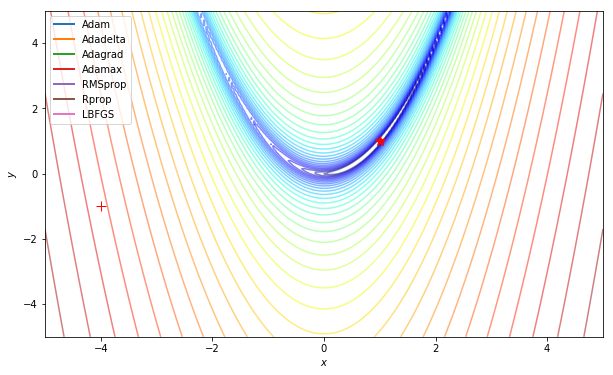

In [569]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.contour(x, y, z, levels=np.logspace(0, 5, 35), norm=LogNorm(), cmap=plt.cm.jet, alpha=0.5)
ax.plot(*minima_, 'r*', markersize=10)
ax.plot(*x0, 'r+', markersize=10)

ax.set_xlabel('$x$')
ax.set_ylabel('$y$')

ax.set_xlim((xmin, xmax))
ax.set_ylim((ymin, ymax))

anim = TrajectoryAnimation(*paths, labels=methods, ax=ax)

ax.legend(loc='upper left')

In [564]:
# anim.to_html5_video()
save_file = '{name:}.m4v'.format(name=f.__name__)

anim.save(save_file)

# display
html="""<video {options}>
  <source type="video/mp4" src="{video}">
  Your browser does not support the video tag.
</video>""".format(options=' '.join(['controls', 'autoplay']), video=save_file)
print(html)
HTML(html)

<video controls autoplay>
  <source type="video/mp4" src="rosenbrock.m4v">
  Your browser does not support the video tag.
</video>


# 3d anim

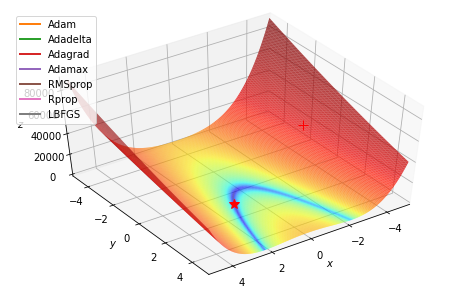

In [590]:
fig = plt.figure(figsize=(8, 5))
ax = plt.axes(projection='3d', elev=50, azim=65)

ax.plot_surface(x, y, z, norm=LogNorm(), rstride=1, cstride=1, edgecolor='none', alpha=.8, cmap=plt.cm.jet)
ax.plot(*minima_, f(minima_), 'r*', markersize=10)
ax.plot(*_x0, f(_x0), 'r+', markersize=10)

ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_zlabel('$z$')

ax.set_xlim((xmin, xmax))
ax.set_ylim((ymin, ymax))

anim = TrajectoryAnimation3D(*paths, zpaths=zpaths, labels=methods, ax=ax)

ax.legend(loc='bottom left')

In [591]:
# anim.to_html5_video()
save_file3d = save_file.replace('.m4v', '_3d.m4v')

anim.save(save_file3d)

# display
html="""<video {options}>
  <source type="video/mp4" src="{video}">
  Your browser does not support the video tag.
</video>""".format(options=' '.join(['controls', 'autoplay']), video=save_file3d)
print(html)
HTML(html)

KeyboardInterrupt: 

# loss anim

same as 2d but instead of x,y it's steps,np.abs(z-zmin)

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.contour(x, y, z, levels=np.logspace(0, 5, 35), norm=LogNorm(), cmap=plt.cm.jet, alpha=0.5)
ax.plot(*minima_, 'r*', markersize=10)
ax.plot(*x0, 'r+', markersize=10)

ax.set_xlabel('$x$')
ax.set_ylabel('$y$')

ax.set_xlim((xmin, xmax))
ax.set_ylim((ymin, ymax))

anim = TrajectoryAnimation(*paths, labels=methods, ax=ax)

ax.legend(loc='upper left')